Bias Analysis

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, precision_recall_fscore_support
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

#Min-Max Normalization
def normalize_scores(scores):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scores = np.array(scores).reshape(-1, 1)
    scaled_scores = scaler.fit_transform(scores)
    return scaled_scores.flatten()

model_files = {
    "CodeBERT": "/content/drive/MyDrive/SEM3_DISSERTATION/Testing/SpecialChars/CodeBERT_results_cosine_with_schars.xlsx",
    "GraphCodeBERT": "/content/drive/MyDrive/SEM3_DISSERTATION/Testing/SpecialChars/GraphCodeBERT_results_cosine_with_schars.xlsx",
    "UnixCoder": "/content/drive/MyDrive/SEM3_DISSERTATION/Testing/SpecialChars/UnixCoder_results_cosine_with_schars.xlsx",
    "CodeT5": "/content/drive/MyDrive/SEM3_DISSERTATION/Testing/SpecialChars/CodeT5_results_cosine_with_schars.xlsx"
}

models = ['CodeBERT', 'GraphCodeBERT', 'UnixCoder', 'CodeT5']
languages = ['py', 'java', 'cs']
thresholds = np.arange(0, 1.01, 0.01)

Overall Performance Across Languages

Raw Cosine Similarity Evaluation


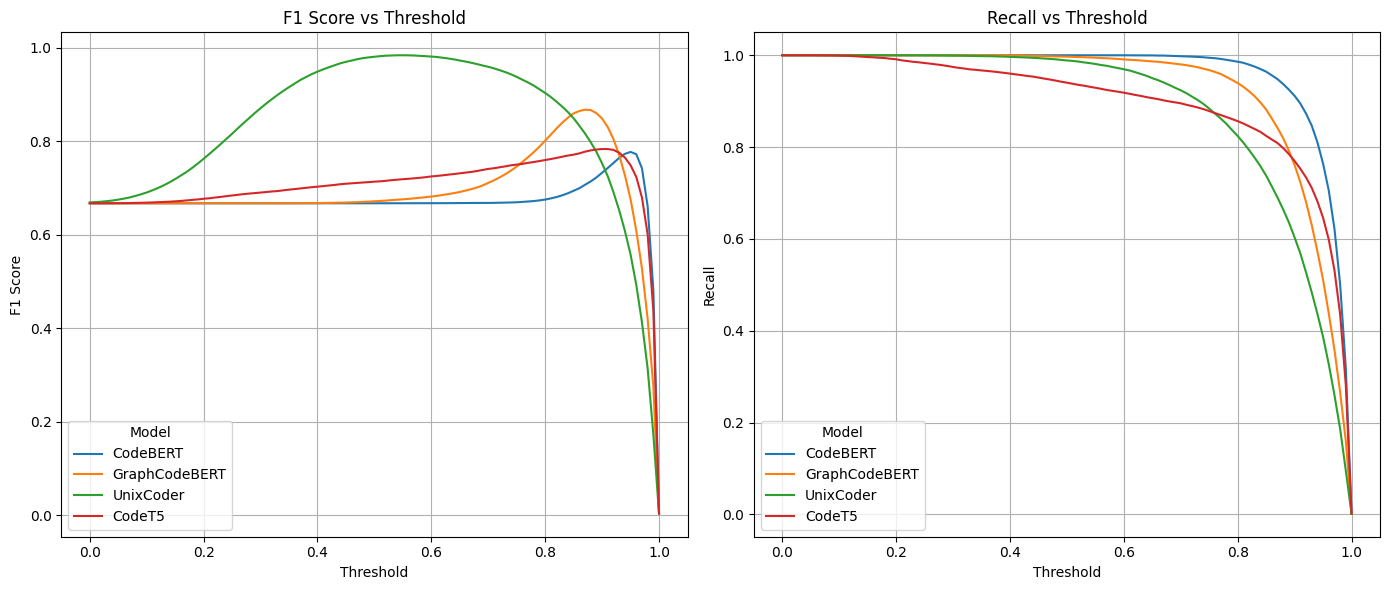


Best Threshold Summary:

CodeBERT
  Precision: 0.7908
  Recall: 0.7641
  F1: 0.7772
  Threshold: 0.9500

GraphCodeBERT
  Precision: 0.8951
  Recall: 0.8418
  F1: 0.8676
  Threshold: 0.8700

UnixCoder
  Precision: 0.9871
  Recall: 0.9810
  F1: 0.9840
  Threshold: 0.5500

CodeT5
  Precision: 0.7975
  Recall: 0.7698
  F1: 0.7834
  Threshold: 0.9000

Per-Language Evaluation at Best Threshold:
            Model Language  Precision    Recall        F1
0        CodeBERT       py   0.839563  0.736047  0.784405
1        CodeBERT     java   0.772285  0.772165  0.772225
2        CodeBERT       cs   0.767157  0.783996  0.775485
3   GraphCodeBERT       py   0.970635  0.813030  0.884870
4   GraphCodeBERT     java   0.858982  0.846345  0.852617
5   GraphCodeBERT       cs   0.867436  0.865883  0.866659
6       UnixCoder       py   0.973077  0.987468  0.980219
7       UnixCoder     java   0.990212  0.968631  0.979303
8       UnixCoder       cs   0.998268  0.987001  0.992602
9          CodeT5       py 

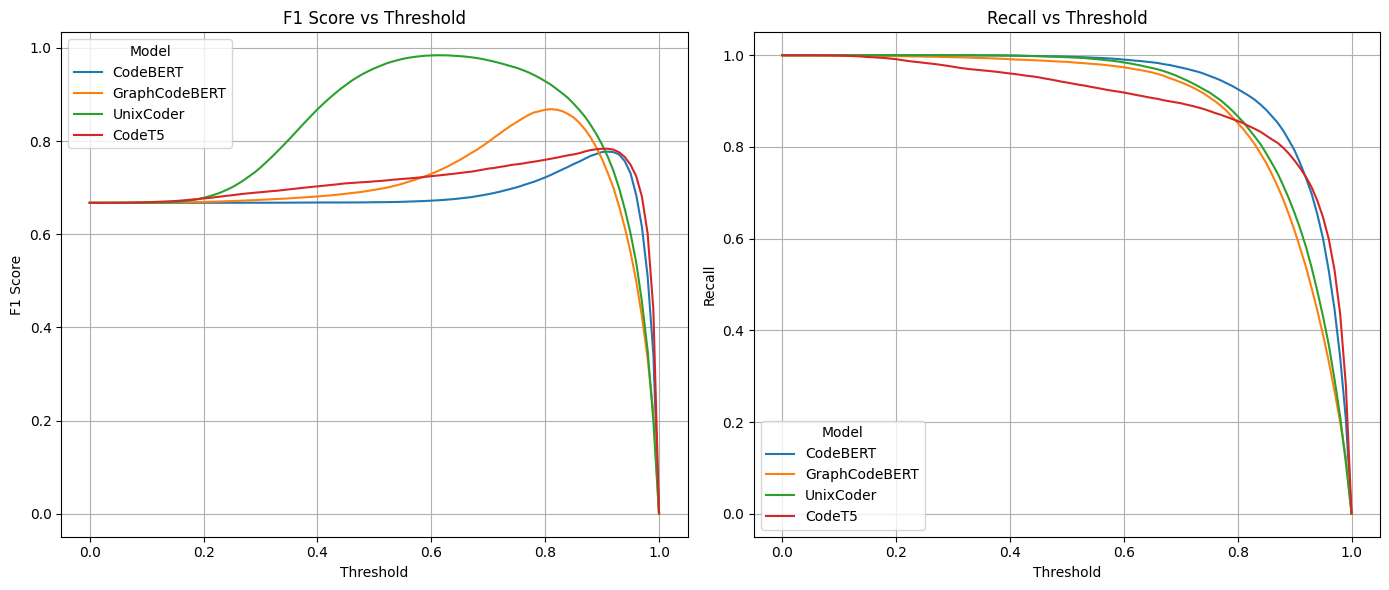


Best Threshold Summary:

CodeBERT
  Precision: 0.7913
  Recall: 0.7637
  F1: 0.7772
  Threshold: 0.9100

GraphCodeBERT
  Precision: 0.9003
  Recall: 0.8386
  F1: 0.8683
  Threshold: 0.8100

UnixCoder
  Precision: 0.9856
  Recall: 0.9824
  F1: 0.9840
  Threshold: 0.6100

CodeT5
  Precision: 0.8161
  Recall: 0.7534
  F1: 0.7835
  Threshold: 0.9100

Per-Language Evaluation at Best Threshold:
            Model Language  Precision    Recall        F1
0        CodeBERT       py   0.840089  0.735658  0.784413
1        CodeBERT     java   0.772919  0.771776  0.772347
2        CodeBERT       cs   0.767378  0.783685  0.775446
3   GraphCodeBERT       py   0.972474  0.808516  0.882948
4   GraphCodeBERT     java   0.864884  0.843543  0.854080
5   GraphCodeBERT       cs   0.874389  0.863704  0.869014
6       UnixCoder       py   0.969771  0.988869  0.979227
7       UnixCoder     java   0.989363  0.970188  0.979682
8       UnixCoder       cs   0.998270  0.988168  0.993194
9          CodeT5       py 

In [ ]:
def evaluate_thresholds(model_files, normalize=False):
    summary_results = {}
    per_language_results = []
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    f1_ax, recall_ax = axes

    for model_name, file_path in model_files.items():
        df = pd.read_excel(file_path)
        if normalize:
            df['probability'] = normalize_scores(df['probability'].values)

        y_true = df['is_semantic_clone'].values
        y_probs = df['probability'].values

        f1_scores, recall_scores = [], []
        best_f1, best_threshold, best_metrics = 0, None, {}

        for t in thresholds:
            y_pred = (y_probs >= t).astype(int)
            precision = precision_score(y_true, y_pred, zero_division=0)
            recall = recall_score(y_true, y_pred, zero_division=0)
            f1 = f1_score(y_true, y_pred, zero_division=0)
            f1_scores.append(f1)
            recall_scores.append(recall)

            if f1 > best_f1:
                best_f1 = f1
                best_threshold = t
                best_metrics = {
                    "Precision": precision,
                    "Recall": recall,
                    "F1": f1,
                    "Threshold": t
                }

        summary_results[model_name] = best_metrics
        f1_ax.plot(thresholds, f1_scores, label=model_name)
        recall_ax.plot(thresholds, recall_scores, label=model_name)

        for lang in languages:
            lang_df = df[df['language']== lang]
            if not lang_df.empty:
                y_true_lang = lang_df['is_semantic_clone'].values
                y_pred_lang = (lang_df['probability'].values >= best_threshold).astype(int)
                precision = precision_score(y_true_lang, y_pred_lang, zero_division=0)
                recall = recall_score(y_true_lang, y_pred_lang, zero_division=0)
                f1 = f1_score(y_true_lang, y_pred_lang, zero_division=0)
                per_language_results.append({
                    'Model': model_name,
                    'Language': lang,
                    'Precision': precision,
                    'Recall': recall,
                    'F1': f1
                })

    f1_ax.set_title("F1 Score vs Threshold")
    f1_ax.set_xlabel("Threshold")
    f1_ax.set_ylabel("F1 Score")
    f1_ax.legend(title="Model")
    f1_ax.grid(True)

    recall_ax.set_title("Recall vs Threshold")
    recall_ax.set_xlabel("Threshold")
    recall_ax.set_ylabel("Recall")
    recall_ax.legend(title="Model")
    recall_ax.grid(True)

    plt.tight_layout()
    plt.show()

    print("\nBest Threshold Summary:")
    for model, metrics in summary_results.items():
        print(f"\n{model}")
        for metric, value in metrics.items():
            print(f"  {metric}: {value:.4f}" if isinstance(value, float) else f"  {metric}: {value}")

    print("\nPer-Language Evaluation at Best Threshold:")
    per_lang_df = pd.DataFrame(per_language_results)
    print(per_lang_df)

    return summary_results, per_language_results

print("Raw Cosine Similarity Evaluation")
raw_results, raw_per_language_results = evaluate_thresholds(model_files, normalize=False)

print("\nNormalized Cosine Similarity Evaluation")
normalized_results, norm_per_language_results = evaluate_thresholds(model_files, normalize=True)

/tmp/ipython-input-3012761015.py:9: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  ax = sns.barplot(


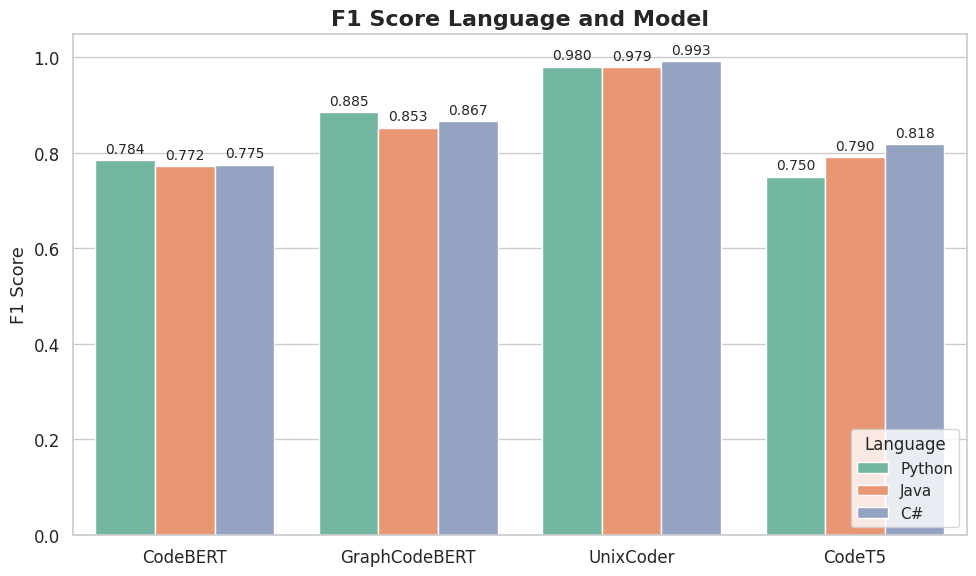

In [ ]:
df = pd.DataFrame(raw_per_language_results).copy()
# df = raw_per_language_results.copy()
df["Language"] = df["Language"].str.lower().replace({"py": "Python", "java": "Java", "cs": "C#"})

sns.set_theme(style="whitegrid", font_scale=1.2)
palette = sns.color_palette("Set2")

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=df,
    x="Model",
    y="F1",
    hue="Language",
    palette=palette
)

for container in ax.containers:
    ax.bar_label(container, fmt="%.3f", padding=3, fontsize=10)

# plot
plt.title("F1 Score Language and Model", fontsize=16, weight='bold')
plt.ylabel("F1 Score", fontsize=13)
plt.xlabel("")
plt.ylim(0, 1.05)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.legend(title="Language", loc='lower right', fontsize=11, title_fontsize=12)
plt.tight_layout()

plt.show()

Intra-Model and Cross-Model Bias Analysis

In [ ]:
dfs = []
for model_name, path in model_files.items():
    df = pd.read_excel(path).copy()
    df['model'] = model_name
    dfs.append(df)


Intra-Model F1-AUC Evaluation
Language           cs    java      py  Average  Standard Deviation
Model                                                             
CodeBERT       0.6733  0.6724  0.6712   0.6723              0.0009
CodeT5         0.7164  0.7167  0.6902   0.7078              0.0124
GraphCodeBERT  0.6937  0.6914  0.6879   0.6910              0.0024
UnixCoder      0.8507  0.8371  0.8121   0.8333              0.0160


/tmp/ipython-input-769543103.py:41: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.barplot(


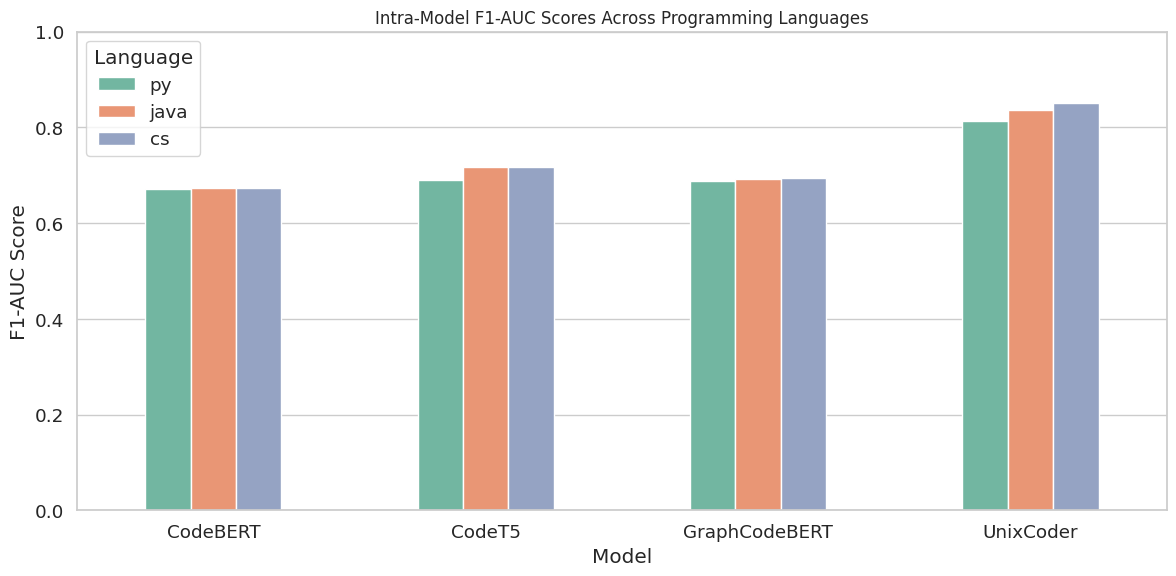


Cross-Model F1-AUC Evaluation
Model     CodeBERT  CodeT5  GraphCodeBERT  UnixCoder  Average  \
Language                                                        
cs          0.6794  0.7174         0.7079     0.8338   0.7347   
java        0.6778  0.7166         0.7037     0.8123   0.7276   
py          0.6752  0.6908         0.6983     0.7970   0.7153   

Model     Standard Deviation  
Language                      
cs                    0.0589  
java                  0.0509  
py                    0.0479  


In [ ]:
# Intra-Model and Cross-Model Bias
combined_df = pd.concat(dfs, ignore_index=True)

# Intra-model normalization
df_intra = combined_df.copy()
df_intra['norm_score'] = df_intra['probability']

# Cross-model normalization
df_cross = combined_df.copy()
df_cross['norm_score'] = df_cross.groupby(['model', 'language'])['probability'].transform(normalize_scores)

results_intra = []
for model in models:
    for lang in languages:
        subset = df_intra[(df_intra['model'] == model) & (df_intra['language'] == lang)]
        y_true = subset['is_semantic_clone'].values
        y_score = subset['norm_score'].values
        f1s = []
        for t in thresholds:
            y_pred = (y_score >= t).astype(int)
            f1 = f1_score(y_true, y_pred, zero_division=0)
            f1s.append(f1)
        auc = np.trapezoid(f1s, thresholds)
        results_intra.append({'Model': model, 'Language': lang, 'F1-AUC': auc})

intra_df = pd.DataFrame(results_intra).pivot(index='Model', columns='Language', values='F1-AUC')
intra_df['Average'] = intra_df.mean(axis=1)
intra_df['Standard Deviation'] = intra_df.std(axis=1)
print("\nIntra-Model F1-AUC Evaluation")
print(intra_df.round(4))

#Visualisation

plot_df = intra_df.drop(columns=['Average', 'Standard Deviation']).reset_index()
plot_df_melted = plot_df.melt(id_vars='Model', var_name='Language', value_name='F1-AUC')

language_order = ['py', 'java', 'cs']
palette = sns.color_palette("Set2")

plt.figure(figsize=(12, 6))
sns.barplot(
    data=plot_df_melted,
    x='Model',
    y='F1-AUC',
    hue='Language',
    palette=palette,
    hue_order=language_order,
    width = 0.5
    )

plt.title('Intra-Model F1-AUC Scores Across Programming Languages', fontsize=12)
plt.ylabel('F1-AUC Score')
plt.xlabel('Model')
plt.ylim(0, 1)
plt.legend(title='Language')

# Show the plot
plt.tight_layout()
plt.show()


results_cross = []
for model in models:
    for lang in languages:
        subset = df_cross[(df_cross['model'] == model) & (df_cross['language'] == lang)]
        y_true = subset['is_semantic_clone'].values
        y_score = subset['norm_score'].values
        f1s = []
        for t in thresholds:
            y_pred = (y_score >= t).astype(int)
            f1 = f1_score(y_true, y_pred, zero_division=0)
            f1s.append(f1)
        auc = np.trapezoid(f1s, thresholds)
        results_cross.append({'Model': model, 'Language': lang, 'F1-AUC': auc})

cross_df = pd.DataFrame(results_cross).pivot(index='Language', columns='Model', values='F1-AUC')
cross_df['Average'] = cross_df.mean(axis=1)
cross_df['Standard Deviation'] = cross_df.std(axis=1)
print("\nCross-Model F1-AUC Evaluation")
print(cross_df.round(4))


Cross-Model Bias Analysis

/tmp/ipython-input-2273238749.py:18: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  sns.barplot(


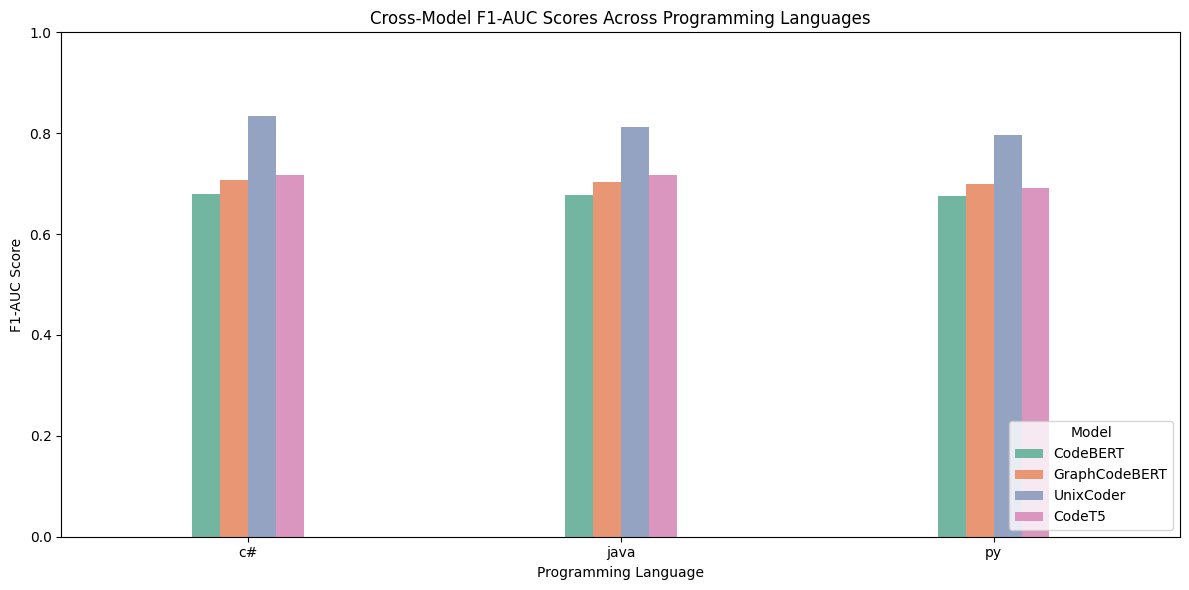

In [ ]:
# Visualisation
plot_df_cross = cross_df.drop(columns=['Average', 'Standard Deviation']).reset_index()
plot_df_cross_melted = plot_df_cross.melt(id_vars='Language', var_name='Model', value_name='F1-AUC')

model_palette = {
    'CodeBERT': '#FFB347',
    'CodeT5': '#87CEFA',
    'GraphCodeBERT': '#90EE90',
    'UnixCoder': '#FF69B4'
}

model_order = ['CodeBERT', 'GraphCodeBERT', 'UnixCoder', 'CodeT5']
language_order = ['py', 'java', 'c#']
model_palette = sns.color_palette("Set2")


plt.figure(figsize=(12, 6))
sns.barplot(
    data=plot_df_cross_melted,
    x='Language',
    y='F1-AUC',
    hue='Model',
    hue_order=model_order,
    palette=model_palette,
    width=0.3
)

plt.title('Cross-Model F1-AUC Scores Across Programming Languages', fontsize=12)
plt.ylabel('F1-AUC Score')
plt.xlabel('Programming Language')
plt.ylim(0, 1)
plt.legend(title='Model', loc='lower right')
plt.tight_layout()
plt.show()


Correlation Analysis - Task 1

In [ ]:
from scipy.stats import pearsonr

training_data = {
    'CodeBERT': {'java': 2070643, 'py': 1614304, 'cs':0},
    'GraphCodeBERT': {'java': 542991, 'py': 503502, 'cs':0},
    "UnixCoder": {'java': 2070643, 'py': 1614304, 'cs':0},
    'CodeT5': {'java': 1527652, 'py': 1110802, 'cs': 1084871}
}

def prepare_training_data(languages):
    records = []
    for model, token_counts in training_data.items():
        total_tokens = sum(token_counts[lang] for lang in languages)

        if total_tokens == 0:
            continue  # Skip
        for lang in languages:
            proportion = token_counts[lang] / total_tokens if total_tokens > 0 else 0
            records.append({
                "Model": model,
                "Language": lang,
                "Tokens": token_counts[lang],
                "Normalized Tokens": proportion
            })
    return pd.DataFrame(records)

def correlation_training_effectiveness(results_intra, languages):

    training_df = prepare_training_data(languages)

    f1_auc_melted = results_intra.drop(columns=["Average", "Standard Deviation"], errors="ignore")
    f1_auc_melted = f1_auc_melted.reset_index().melt(id_vars="Model",
                                                     value_vars=languages,
                                                     var_name="Language",
                                                     value_name="F1-AUC")

    merged_df = pd.merge(training_df, f1_auc_melted, on=["Model", "Language"])
    # print("Merged DF", merged_df)

    print("\nCorrelation: Normalized Training Tokens vs F1-AUC")
    for model in models:
        subset = merged_df[merged_df["Model"] == model]
        if len(subset) >= 2:
            corr, p_value = pearsonr(subset["Normalized Tokens"], subset["F1-AUC"])
            print(f"{model}: Pearson Correlation = {corr:.4f}, p-value = {p_value:.4f}")

    return merged_df

correlation_training_effectiveness(intra_df, languages)


Correlation: Normalized Training Tokens vs F1-AUC
CodeBERT: Pearson Correlation = -0.6668, p-value = 0.5353
GraphCodeBERT: Pearson Correlation = -0.7599, p-value = 0.4505
UnixCoder: Pearson Correlation = -0.6188, p-value = 0.5752
CodeT5: Pearson Correlation = 0.4631, p-value = 0.6935


,Model,Language,Tokens,Normalized Tokens,F1-AUC
0,CodeBERT,py,1614304,0.438081,0.671166
1,CodeBERT,java,2070643,0.561919,0.672425
2,CodeBERT,cs,0,0.000000,0.673292
3,GraphCodeBERT,py,503502,0.481133,0.687946
4,GraphCodeBERT,java,542991,0.518867,0.691404
5,GraphCodeBERT,cs,0,0.000000,0.693678
6,UnixCoder,py,1614304,0.438081,0.812095
7,UnixCoder,java,2070643,0.561919,0.837115
8,UnixCoder,cs,0,0.000000,0.850737
9,CodeT5,py,1110802,0.298336,0.690174


Correlation Analysis - Task 2

In [ ]:
import numpy as np
from itertools import combinations

token_counts = {
    'CodeBERT':       [2070643, 1614304, 0],
    'GraphCodeBERT':  [542991, 503502, 0],
    'CodeT5':         [1527652, 1110802, 1084871],
    'UnixCoder':      [2070643, 1614304, 0]
}


performance_std = {
    'CodeBERT':     0.0009,
    'GraphCodeBERT':0.0024,
    'CodeT5':       0.0124,
    'UnixCoder':    0.0160
}

cvs = []
perf_stds = []

for model, tokens in token_counts.items():
    tokens_array = np.array(tokens, dtype=float)
    mean = np.mean(tokens_array)
    std = np.std(tokens_array)
    cv = std / (mean + 1e-9)
    cvs.append(cv)

    perf_stds.append(performance_std[model])

# CV vs Performance Std Dev
corr_cv, p_cv = pearsonr(cvs, perf_stds)

print("\n Correlation Results:\n")
print(f"Coefficient of Variation vs Performance Std Dev:")
print(f" Pearson Correlation = {corr_cv:.4f}")
print(f" p-value             = {p_cv:.4f}")


 Correlation Results:

Coefficient of Variation vs Performance Std Dev:
 Pearson Correlation = -0.3925
 p-value             = 0.6075
